In [6]:
import deblend
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

In [7]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


In [8]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


In [9]:
# Choose a good lens system, with large imsep and 4 images:
                      
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1895
Number of these with 4 images =  275
Number of these with i3 < 22 =  113


OM10: Extracted OM10 lens number 2177486:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
2177486        0    3 0.356 ...         22.81 22.5897714339 23.5541069831
multiplication factor :  4.23610270531e-07
3.39136429536
PSF_sigma:  1.179618
currLensX:  -1.1362 currLensY:  -0.3285
multiplication factor :  3.39136429536
59.1923554994
PSF_sigma:  1.179618
currLensX:  -0.6331 currLensY:  0.6957
multiplication factor :  59.1923554994
1.75426985784
PSF_sigma:  1.179618
currLensX:  -0.1621 currLensY:  1.0179
multiplication factor :  1.75426985784
(array([[  6.43211462e+05,   2.80040854e+08,   1.30981264e+11,
          6.49177184e+13],
       [  3.63409107e+08,   1.58417235e+11,   7.41682536e+13,
          3.67902010e+16],
       [  2.14616171e+11,   9.36467078e+13,   4.38779505e+16,
          2.17794441e+19],
       [  1.31719855e+14,   5.75210316e+16,   2.69685869e+19,
          1.33935382e+2

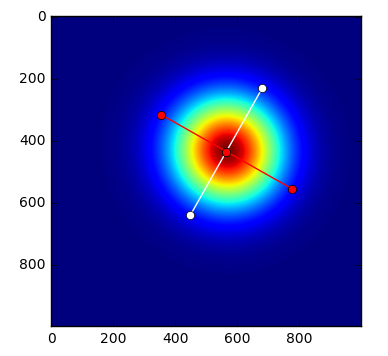

#####################BEFORE DEBLEND PLOT LENSES##################################


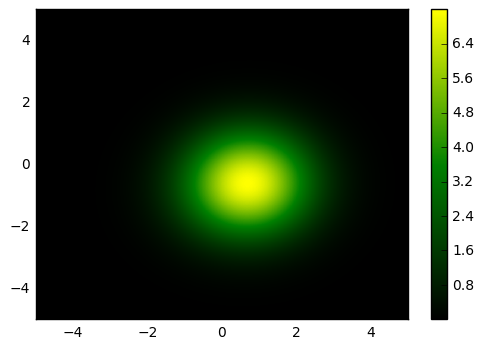

moment_matrix:  [[  6.43211462e+05   2.80040854e+08   1.30981264e+11   6.49177184e+13]
 [  3.63409107e+08   1.58417235e+11   7.41682536e+13   3.67902010e+16]
 [  2.14616171e+11   9.36467078e+13   4.38779505e+16   2.17794441e+19]
 [  1.31719855e+14   5.75210316e+16   2.69685869e+19   1.33935382e+22]]
643211.461872 564.991652917 435.37914156 [[ 0.51874616  0.38290839]
 [ 0.38290839  0.31659323]]
643211.461872 sum of the image values
[[ 14447.90695898    305.48244036]
 [   305.48244036  14081.3997796 ]] different covariance matrix


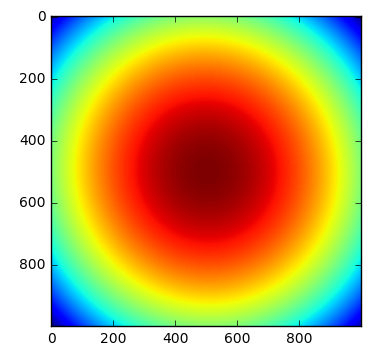

#####################PRINTING NULL DEBLENDER'S PLOT###############################


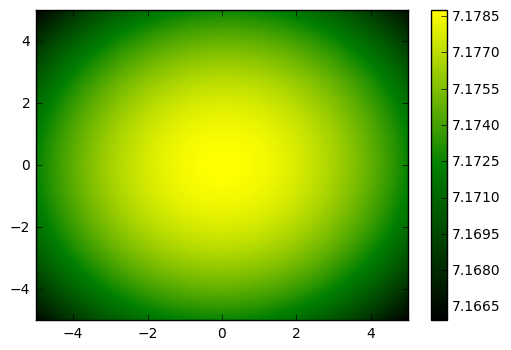

###############################################################################
('Chi squared distance is : ', Power_divergenceResult(statistic=39650233222902.281, pvalue=0.0))
('KL distance is : ', 3.6685429350505392)


In [10]:
realizer.deblend(lensID=k, null_deblend=True, debug=False, show_plot=True)